## 02_transfer_learning_vgg16_frozen_backbone.ipynb
This notebook continues from 01_data_loading_and_eda.ipynb  
- Same dataset loading logic (repeated for reproducibility)  
- Added data augmentation, normalization  
- Transfer learning with VGG16 (frozen backbone) → 88.1% val accuracy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "data3a/training",
    labels="inferred",         
    label_mode="int",          
    batch_size=None,
    image_size=(256, 256),      
    shuffle=True,
)

class_names = train_ds.class_names
class_names

Found 1383 files belonging to 3 classes.


2025-12-07 21:16:30.255161: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-12-07 21:16:30.255191: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-07 21:16:30.255199: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-07 21:16:30.255218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 21:16:30.255227: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['01-minor', '02-moderate', '03-severe']

In [4]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data3a/validation",
    labels="inferred",
    label_mode="int",
    batch_size=None,
    image_size=(256, 256),
    shuffle=False,
)


Found 248 files belonging to 3 classes.


## Splitting Data to Val and Train

In [5]:
val_size = int(len(train_ds) * 0.15)

val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

In [6]:
print(f"Size of the Train Dataset: {len(train_ds)}")
print(f"Size of the Validation Dataset: {len(val_ds)}")
print(f"Size of the Test Dataset: {len(test_ds)}")

Size of the Train Dataset: 1176
Size of the Validation Dataset: 207
Size of the Test Dataset: 248


## Build a best dataloader

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (train_ds
            .shuffle(1000)
            .batch(32)
            .prefetch(AUTOTUNE)
)

val_ds = (val_ds
            .batch(32)
            .prefetch(AUTOTUNE)
)

test_ds = (test_ds
            .batch(32)
            .prefetch(AUTOTUNE)
)

In [8]:
print(f"Length of the Train Batch: {len(train_ds)}")
print(f"Length of the Validation Batch: {len(val_ds)}")
print(f"Length of the test Batch: {len(test_ds)}")

Length of the Train Batch: 37
Length of the Validation Batch: 7
Length of the test Batch: 8


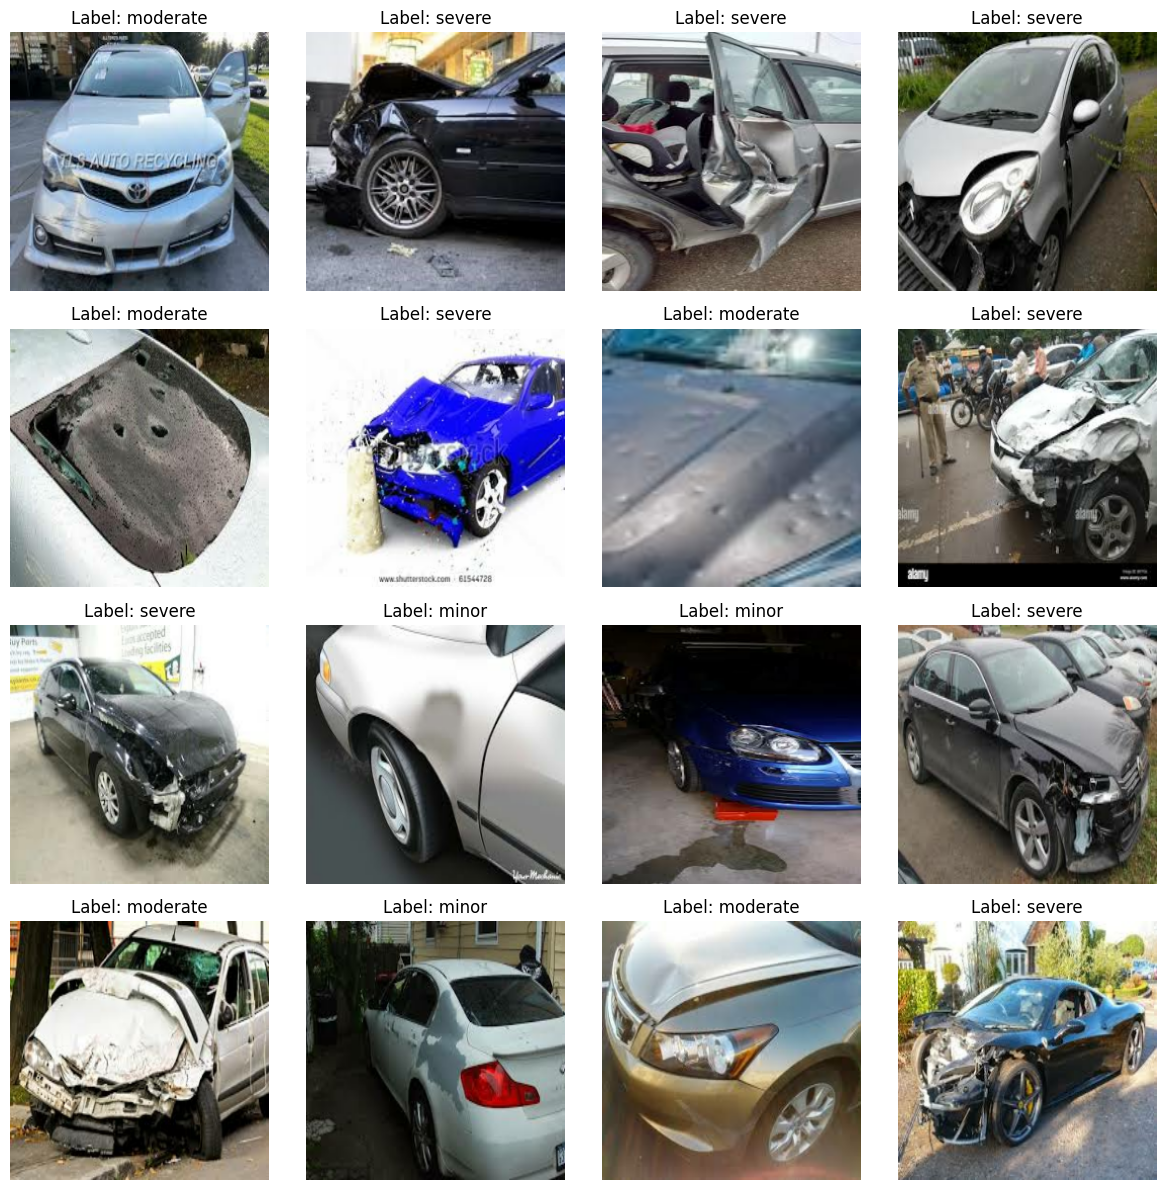

In [9]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(12, 12))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    title = class_names[labels[i].numpy()]
    plt.title(f"Label: {title[3:]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Preprocessing

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds_n = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds_n = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds_n = test_ds.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(train_ds_n))
first_image = image_batch[0]

print(f"min value of image: {np.min(first_image)} and max value of image: {np.max(first_image)}")


min value of image: 0.0 and max value of image: 1.0


## Data Augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds_n_ug = train_ds_n.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

2025-12-07 21:17:05.270444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-07 21:17:05.683933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_21}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-12-07 21:17:05.683976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_21}}]]
	 [[sequential_1/random_rotation_1/add/_16]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-12-07 21:17:05.683982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5654687130291710728
2025-12-07 21:17:05.683989: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key ha

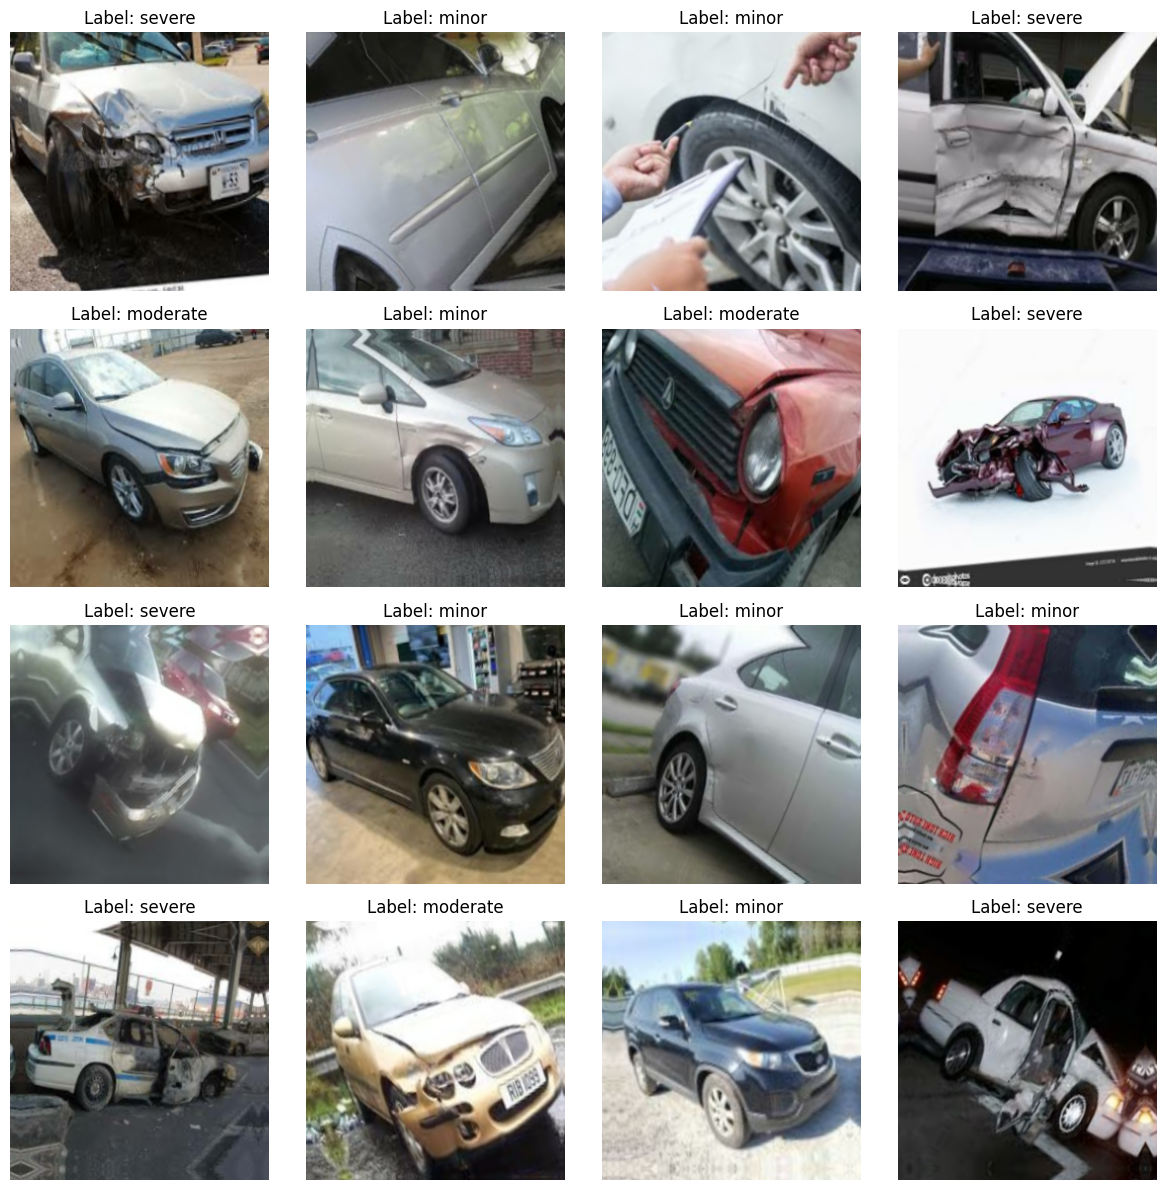

In [12]:
images, labels = next(iter(train_ds_n_ug))

plt.figure(figsize=(12, 12))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    title = class_names[labels[i].numpy()]
    plt.title(f"Label: {title[3:]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## ResNet50

In [13]:
input_shape = (256, 256, 3)
num_classes = 3

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

base_model.trainable = False


inputs = layers.Input(shape=input_shape)

# Base
x = base_model(inputs, training=False)

# --- Strong Classification Head ---
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         restore_best_weights=True)

In [16]:
history = model.fit(
    train_ds_n,
    validation_data=val_ds_n,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - accuracy: 0.4838 - loss: 1.3401 - val_accuracy: 0.3430 - val_loss: 28.3048
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.5166 - loss: 1.0202 - val_accuracy: 0.4155 - val_loss: 4.6486
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.5025 - loss: 0.9861 - val_accuracy: 0.4251 - val_loss: 1.2187
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.5320 - loss: 0.9333 - val_accuracy: 0.4541 - val_loss: 2.0721
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.5713 - loss: 0.9176 - val_accuracy: 0.4783 - val_loss: 1.1301
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.5925 - loss: 0.8735 - val_accuracy: 0.4541 - val_loss: 2.2745
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.5466 - loss: 0.9146 - val_accuracy: 0.3478 - val_loss: 3.1944
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.5989 - loss: 0.8621 - val_accuracy: 

Text(0.5, 0, 'Number of Epochs')

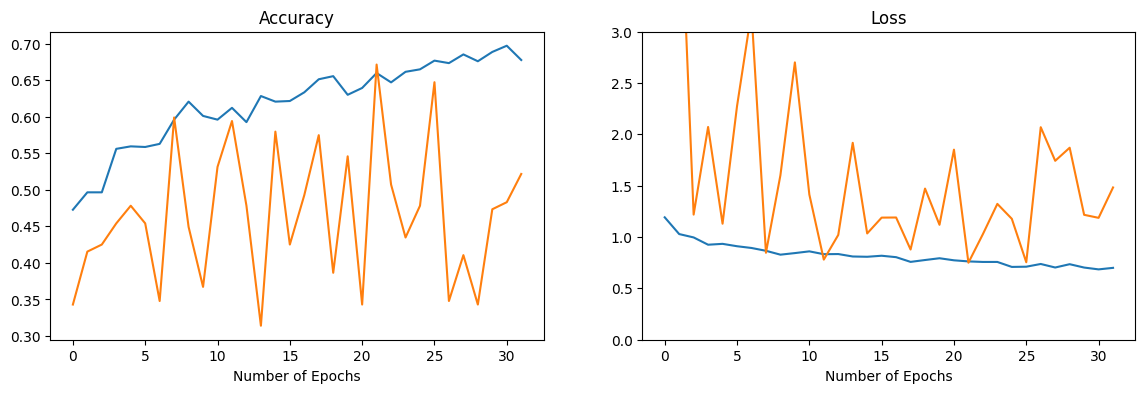

In [17]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epoch_size = len(history.history["val_accuracy"])

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig , ax = plt.subplots(1,2, figsize=(14,4))
x = np.arange(epoch_size)
ax[0].plot(x, train_acc, label = "Train")
ax[0].plot(x, val_acc, label = "Validation")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Number of Epochs")

ax[1].plot(x, train_loss, label = "Train")
ax[1].plot(x, val_loss, label = "Validation")
ax[1].set_title("Loss")
ax[1].set_ylim([0,3])
ax[1].set_xlabel("Number of Epochs")

In [18]:
loss_test, acc_test = model.evaluate(test_ds_n)
print(f"the loss of the test Dataset:{loss_test.__round__(3)} and Accuracy: {acc_test.__round__(3)}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.6140 - loss: 0.7938
the loss of the test Dataset:0.88 and Accuracy: 0.569


## Custom Model

In [19]:
from tensorflow.keras import layers, models, optimizers

# Define the model
model_custom = models.Sequential()

# Convolutional and pooling layers
model_custom.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_custom.add(layers.MaxPooling2D((2, 2)))

model_custom.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_custom.add(layers.MaxPooling2D((2, 2)))

model_custom.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_custom.add(layers.MaxPooling2D((2, 2)))


model_custom.add(layers.Flatten())


model_custom.add(layers.Dense(256, activation='relu'))
model_custom.add(layers.Dropout(0.3))

model_custom.add(layers.Dense(128, activation='relu'))
model_custom.add(layers.Dropout(0.3))


model_custom.add(layers.Dense(3, activation='softmax'))

# Compile the model
model_custom.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50

history = model_custom.fit(
    train_ds_n,
    epochs=epochs,
    validation_data=val_ds_n,
    callbacks = [early_stopping]
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.3206 - loss: 1.1440 - val_accuracy: 0.3092 - val_loss: 1.0889
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.3793 - loss: 1.0893 - val_accuracy: 0.3527 - val_loss: 1.0627
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.4493 - loss: 1.0413 - val_accuracy: 0.5845 - val_loss: 0.9247
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.5396 - loss: 0.9751 - val_accuracy: 0.5990 - val_loss: 0.8691
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5687 - loss: 0.9071 - val_accuracy: 0.6135 - val_loss: 0.8748
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5986 - loss: 0.8679 - val_accuracy: 0.6715 - val_loss: 0.7888
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.6518 - loss: 0.7933 - val_accuracy: 0.7729 - val_loss: 0.6779
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.6823 - loss: 0.7552 - val_accuracy: 0.

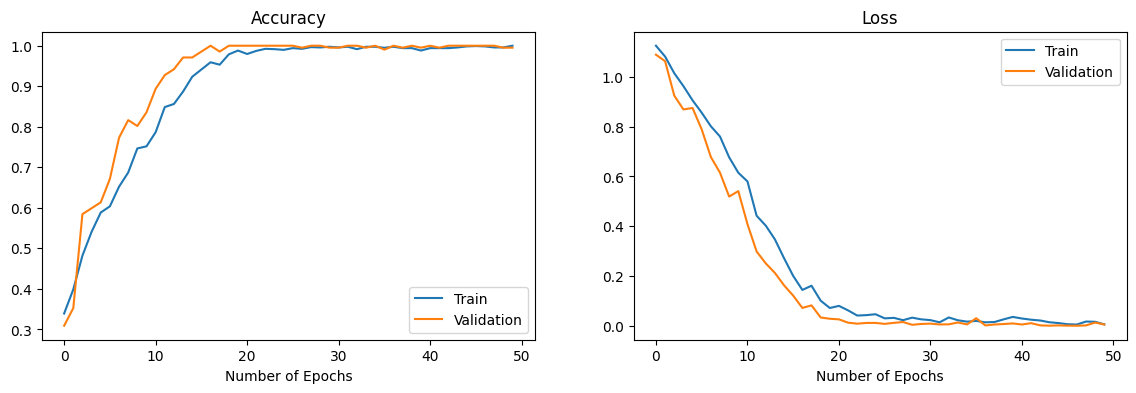

In [20]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epoch_size = len(history.history["val_accuracy"])

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig , ax = plt.subplots(1,2, figsize=(14,4))
x = np.arange(epoch_size)
ax[0].plot(x, train_acc, label = "Train")
ax[0].plot(x, val_acc, label = "Validation")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].legend()

ax[1].plot(x, train_loss, label = "Train")
ax[1].plot(x, val_loss, label = "Validation")
ax[1].set_title("Loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].legend()

In [21]:
loss_test, acc_test = model_custom.evaluate(test_ds_n)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5923 - loss: 2.3229


## vgg16

In [22]:
input_shape = (256, 256, 3)
num_classes = 3

base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=input_shape
)

base_model.trainable = False


inputs = layers.Input(shape=input_shape)

# Base
x = base_model(inputs, training=False)

# --- Strong Classification Head ---
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

x = layers.Dense(128, activation="relu")(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

vgg16 = models.Model(inputs, outputs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [23]:
vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [24]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         restore_best_weights=True)

In [25]:
history = vgg16.fit(
    train_ds_n,
    validation_data=val_ds_n,
    epochs=50,
    callbacks = [early_stopping]
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.5034 - loss: 1.3344 - val_accuracy: 0.3865 - val_loss: 2.4383
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5899 - loss: 0.8613 - val_accuracy: 0.4589 - val_loss: 1.2437
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6170 - loss: 0.8187 - val_accuracy: 0.5411 - val_loss: 0.9106
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.6508 - loss: 0.7465 - val_accuracy: 0.5797 - val_loss: 0.8299
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6726 - loss: 0.7201 - val_accuracy: 0.6522 - val_loss: 0.8216
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6729 - loss: 0.7316 - val_accuracy: 0.6570 - val_loss: 0.7068
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6979 - loss: 0.6974 - val_accuracy: 0.6860 - val_loss: 0.7157
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 347ms/step - accuracy: 0.6971 - loss: 0.6914 - val_accuracy: 0.7440 - val_lo

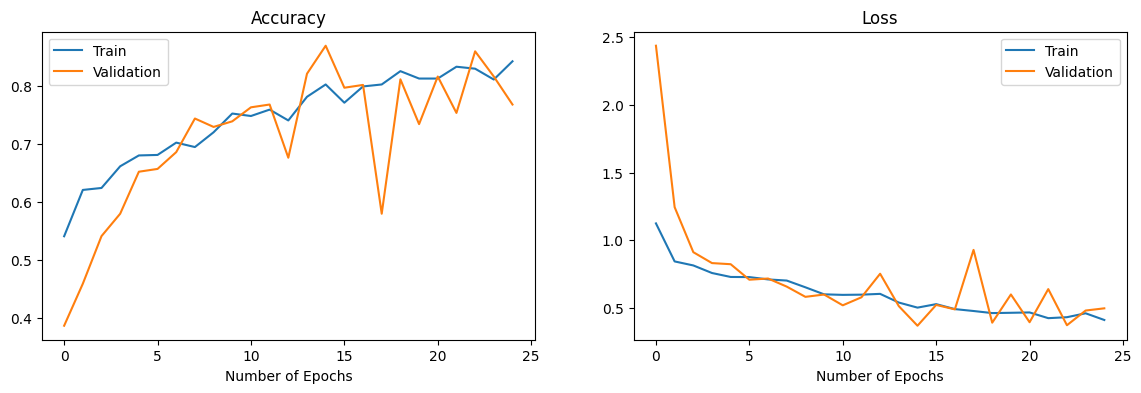

In [26]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epoch_size = len(history.history["val_accuracy"])

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig , ax = plt.subplots(1,2, figsize=(14,4))
x = np.arange(epoch_size)
ax[0].plot(x, train_acc, label = "Train")
ax[0].plot(x, val_acc, label = "Validation")
ax[0].set_title("Accuracy")
ax[0].set_xlabel("Number of Epochs")
ax[0].legend()

ax[1].plot(x, train_loss, label = "Train")
ax[1].plot(x, val_loss, label = "Validation")
ax[1].set_title("Loss")
ax[1].set_xlabel("Number of Epochs")
ax[1].legend()

In [27]:
loss_vgg16, acc_vgg16 = vgg16.evaluate(test_ds_n)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.6662 - loss: 0.8714


In [28]:
print(f"Loss VGG16 : {loss_vgg16.__round__(2)}")
print(f"Accuracy VGG16 : {acc_vgg16.__round__(2)}")

Loss VGG16 : 1.05
Accuracy VGG16 : 0.62
